In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylablib as pll
from pylablib.devices import Thorlabs
import ipywidgets as widgets
import threading
from IPython.display import display, Image
import time
import io
orig_backend = plt.get_backend()
print(f'Cameras attached: {Thorlabs.list_cameras_tlcam()}')
cam1 = Thorlabs.ThorlabsTLCamera()
plt.rcParams['figure.figsize'] = [8.0, 6.0] # make the figures display a bit bigger than default
plt.rcParams['font.size'] = 10 # and with a bigger font size

# Define centroid calculation
def calculate_centroid(intensity_matrix):
    x_coords = np.arange(intensity_matrix.shape[1])
    y_coords = np.arange(intensity_matrix.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)
    
    total_intensity = np.sum(intensity_matrix)
    x_centroid = np.sum(X * intensity_matrix) / total_intensity
    y_centroid = np.sum(Y * intensity_matrix) / total_intensity
    return x_centroid, y_centroid

# 计算激光宽度平方
def calculate_width_squared(intensity_matrix, centroid):
    x_coords = np.arange(intensity_matrix.shape[1])
    y_coords = np.arange(intensity_matrix.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)
    
    x_centroid, y_centroid = centroid
    total_intensity = np.sum(intensity_matrix)
    w_squared_x = 4 * np.sum((X - x_centroid)**2 * intensity_matrix) / total_intensity
    w_squared_y = 4 * np.sum((Y - y_centroid)**2 * intensity_matrix) / total_intensity
    return w_squared_x, w_squared_y

Cameras attached: ['12524']


In [8]:
exposure = 5e-5    # 2.5e-4 ~ 2.5e-3

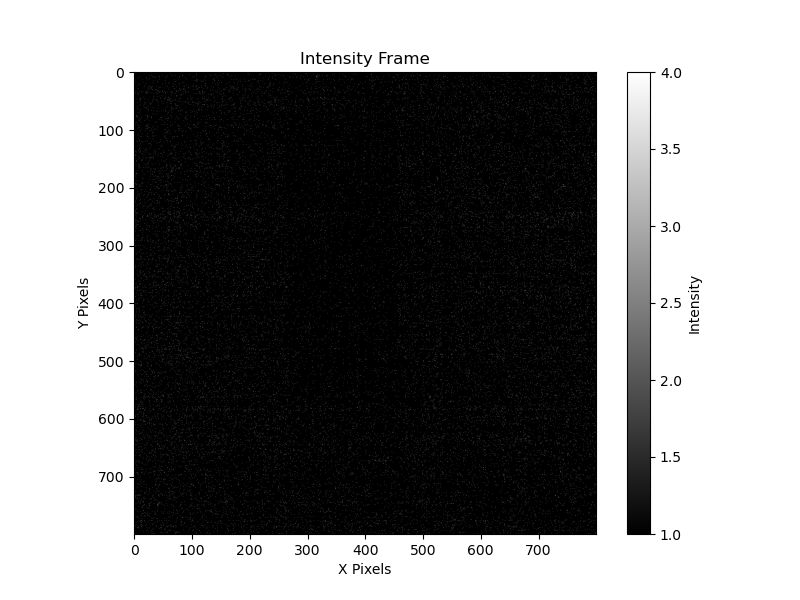

Background Noise: 1.03991875


In [16]:
#拍摄底噪照片，平均每一个像素点
fig = plt.figure()
if not cam1.is_opened():
    cam1 = Thorlabs.ThorlabsTLCamera()
#cam1.set_roi(hbin=2, vbin=2) # set binning to 2 in each axis
cam1.set_exposure(exposure)
background = cam1.snap() #<------------------------------------------底噪被命名为background
#p = np.percentile(background, [5, 99])
#plt.imshow(background, vmin=p[0], vmax=p[1])
#print(background.shape)

plt.imshow(background, cmap='gray')  # Use grayscale colormap for intensity
plt.colorbar(label="Intensity")  # Add a colorbar for reference
plt.title("Intensity Frame")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

intensity_background = background # Compute overall intensity matrix

# Calculate the average 噪声取平均值，拍一张照片取平均值
noise = np.mean(intensity_background)
print("Background Noise:", noise)

In [17]:
import threading

#exposure = 2.5

# Global array and lock for thread safety
data_array = np.empty((0, 3))
data_lock = threading.Lock()


def live_view_4():    # This  works
    N = 800  # size of image region
    x0 = 720
    y0 = 540
    x_centroid = None  # Initialize as None
    y_centroid = None  # Initialize as None
    data_array = np.empty((0, 2))  # Clear previous data
    
    # Control widgets
    # ================
    stopButton = widgets.ToggleButton(
        value=False,
        description='Stop',
        disabled=False,
        button_style='danger',  # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Description',
        icon='square'  # (FontAwesome names without the `fa-` prefix)
    )

    saveButton = widgets.ToggleButton(
        value=False,
        description='Save Frame',
        disabled=False,
        button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Save the current frame and user input',
        icon='save'  # (FontAwesome names without the `fa-` prefix)
    )

    user_input = widgets.Text(
        value='',
        placeholder='Type something',
        description='User Input:',
        disabled=False
    )

    line_x = widgets.IntSlider(value=N // 2, min=0, max=N - 1, description='Line x:')
    line_y = widgets.IntSlider(value=N // 2, min=0, max=N - 1, description='Line y:')
    exposure = widgets.IntSlider(value=20, min=0, max=40, description='Exposure:')
    image = widgets.Image(layout=widgets.Layout(width='1000px', height='500px'))

    if cam1.is_opened():
        cam1.close()  # so that we can open it inside the thread

    # Display function
    # ================
    def view(button, save_button, user_input, line_x, line_y, exposure):
        global data_array, data_lock
        try:
            cam1 = Thorlabs.ThorlabsTLCamera()
            display_handle = display(None, display_id=True)
            fig, axs = plt.subplot_mosaic([['image', 'linescan_x'], ['image', 'linescan_y']],
                                          constrained_layout=True, figsize=(12.0, 6.0))
            #cam1.set_exposure(exposure.value*1e-5)# <-----------------------------------------------------------------------------
            cam1.set_roi(2 * (x0 - N / 2), 2 * (x0 + N / 2), 2 * (y0 - N / 2), 2 * (y0 + N / 2))
            cam1.setup_acquisition(nframes=100)  # could be combined with start_acquisition, or kept separate
            cam1.start_acquisition()
            #last_exp = 10*0.000001
            plt.figure(fig)

            # Initialize centroid variables
            x_centroid = None
            y_centroid = None

            while not button.value:
                plt.clf()
                #exp = exposure.value
                #if exp != last_exp:
                #    cam1.set_exposure(exp * 0.00001)
                #    last_exp = exp
                cam1.set_exposure(0.5e-4)# <-----------------------------------------------------------------------------
                cam1.wait_for_frame()
                frame = cam1.read_newest_image()

                # Save the frame and user input if the save button is pressed
                if save_button.value:
                    
                    # Save the frame and user input together
                    print(f"Proceed one calculation. User input: {user_input.value}")
                    intensity_matrix = frame - noise - 3
                    intensity_matrix[intensity_matrix < 0] = 0

                    centroid = calculate_centroid(intensity_matrix)
                    print(f"Centroid coordinates: {centroid}")
                    
                    width_squared = calculate_width_squared(intensity_matrix, centroid)
                    print(f"Laser width squared: {width_squared}")
                    

                    Z_position = user_input.value
                    print(f"User input Z position: {Z_position}")

                    # Append the new data to the global array with thread safety
                    #new_data = np.array([[float(Z_position), width_squared]])
                    new_data = np.array([[float(Z_position), width_squared[0], width_squared[1]]])
                    with data_lock:
                        data_array = np.append(data_array, new_data, axis=0)
                    print(f"DATA ARRAY: {data_array}")
                    
                    # Plot a blue cross at the centroid location on the image
                    x_centroid, y_centroid = centroid
                    #print("Intensity matrix min/max:", np.min(intensity_matrix), np.max(intensity_matrix))
                    #print("Centroid:", centroid)
                    #print("Total intensity:", total_intensity)
                
                    save_button.value = False  # Reset the button after saving

                #p = np.percentile(frame, [5, 99])
                plt.axes(axs['image'])
                plt.cla()
                #plt.imshow(frame, cmap="gray", vmin=p[0], vmax=p[1])
                plt.imshow(frame, cmap="gray")

                if x_centroid is not None and y_centroid is not None:
                    plt.scatter(x_centroid, y_centroid, color='blue', s=100, marker='x', label="Centroid")

                
                line_no_x = line_x.value
                plt.hlines(line_no_x, 0, N - 1, color='red')
                line_no_y = line_y.value
                plt.vlines(line_no_y, 0, N - 1, color='red')
                plt.axes(axs['linescan_x'])
                plt.cla()
                plt.plot(frame[line_no_x, :])
                plt.title(f'intensity at row: {line_no_x}')
                plt.axes(axs['linescan_y'])
                plt.cla()
                plt.plot(frame[:, line_no_y])
                plt.title(f'intensity at column: {line_no_y}')
                buf = io.BytesIO()
                fig.savefig(buf)
                buf.seek(0)
                image.value = buf.read()
                            
        finally:
            cam1.close()
            plt.clf()
            plt.switch_backend(orig_backend)
            print("Done")

    # Run
    # ================
    display(stopButton, saveButton, user_input, line_x, line_y, exposure, image)
    thread = threading.Thread(target=view, args=(stopButton, saveButton, user_input, line_x, line_y, exposure))
    thread.start()

In [18]:
data_array = np.empty((0, 3))
live_view_4()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

ToggleButton(value=False, button_style='info', description='Save Frame', icon='save', tooltip='Save the curren…

Text(value='', description='User Input:', placeholder='Type something')

IntSlider(value=400, description='Line x:', max=799)

IntSlider(value=400, description='Line y:', max=799)

IntSlider(value=20, description='Exposure:', max=40)

Image(value=b'', layout="Layout(height='500px', width='1000px')")

None

Proceed one calculation. User input: 19.5
Centroid coordinates: (287.05556194893916, 269.52409273270996)
Laser width squared: (350.09025048622243, 301.88470955552077)
User input Z position: 19.5
DATA ARRAY: [[ 19.5        350.09025049 301.88470956]]
Proceed one calculation. User input: 20
Centroid coordinates: (284.1369434355265, 261.28419681809044)
Laser width squared: (352.5380464745279, 337.0113428837455)
User input Z position: 20
DATA ARRAY: [[ 19.5        350.09025049 301.88470956]
 [ 20.         352.53804647 337.01134288]]
Proceed one calculation. User input: 20.5
Centroid coordinates: (283.03869142322907, 252.62914950606563)
Laser width squared: (514.9223285922018, 574.9201045917846)
User input Z position: 20.5
DATA ARRAY: [[ 19.5        350.09025049 301.88470956]
 [ 20.         352.53804647 337.01134288]
 [ 20.5        514.92232859 574.92010459]]
Proceed one calculation. User input: 21
Centroid coordinates: (283.6051809402107, 243.05028215560114)
Laser width squared: (877.24650